<a href="https://colab.research.google.com/github/hiendtt95/tanksystem/blob/master/DT_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# ADD MODULE PATH - TO IMPORT CUSTOM CONSTANTs, CLASSes
# Modules Path
BASE_PATH = '/content/drive/My Drive/WORKING - InSecLab/Google Colab/GAN/X.Leopard/Run_On_CICIDS-2018/'
ModulePath = BASE_PATH + '2. Colab/Modules'

import sys
sys.path.append(ModulePath)
from constants import *
from models import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **1. LIBS, PATHS & CONTS**

## **LIBS**

In [2]:
# !pip3 numpy torc sklearn matplotlib pandas

In [3]:
import numpy as np
import pandas as pd
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import pickle

# Libs for Keras
from keras.models import load_model

import matplotlib.pyplot as plt
import math
import os
from datetime import date
import timeit

## **PATHS**

In [4]:
# Dataset Path
g_trainset_path = TRAINSET_PATH + "GAN-G.csv"
d_trainset_path = TRAINSET_PATH + "GAN-D.csv"
testset_path = TESTSET_FILE_PATH
testset_path

'/content/drive/My Drive/WORKING - InSecLab/Google Colab/GAN/X.Leopard/Run_On_CICIDS-2018/1. Dataset/CICIDS-2018_FINAL_4USING/Testset.csv'

In [5]:
# Functional Features of DoS Attack Traffics (REFERENCE: SIGMA : Strengthening IDS with GAN and Metaheuristics Attacks)
s = "Flow Duration, Active Mean, Average Packet Size, Packet Length Std, Flow IAT Mean, PSH Flag Count, Idle Max"
short_names = {'Packet Length Std': 'Pkt Len Std', 'PSH Flag Count': 'PSH Flag Cnt', 'Average Packet Size': 'Pkt Size Avg'}
for full_name, short_name in short_names.items():
    s = s.replace(full_name, short_name)    

dos_functional_feature=s.split(', ')
dos_functional_feature

['Flow Duration',
 'Active Mean',
 'Pkt Size Avg',
 'Pkt Len Std',
 'Flow IAT Mean',
 'PSH Flag Cnt',
 'Idle Max']

## **CONSTS**

In [6]:
testset = pd.read_csv(testset_path)
testset

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.000809,1.000000,6.516667e-06,0.000000,0.000052,0.000003,0.000004,0.000466,0.020548,0.001815,0.000000,0.011510,0.085034,0.051126,0.000000,1.278615e-04,6.385654e-04,6.522683e-06,0.000000,6.517127e-06,6.525461e-06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000039,0.000021,3.192819e-04,6.385696e-04,0.020548,0.001552,0.016030,0.003820,0.000015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007937,0.024036,0.001815,0.051126,0.000000,0.000003,0.000052,0.000004,0.000000,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,0.772454,0.352941,0.000000e+00,0.000111,0.000000,0.000006,0.000000,0.000822,0.000000,0.001603,0.002037,0.000000,0.000000,0.000000,0.000000,4.081633e-02,5.000000e-01,5.555948e-09,0.000000,0.000000e+00,8.333922e-09,8.333340e-09,8.333922e-09,0.000000,8.333922e-09,8.333922e-09,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.0,0.000195,0.000000,5.000000e-01,0.000000e+00,0.000000,0.000822,0.010620,0.002892,0.000008,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.015924,0.001603,0.000000,0.000111,0.000006,0.000000,0.000000,0.083923,0.000000,0.000000,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,0.758141,0.352941,1.416667e-07,0.000000,0.000052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.777777e-02,1.472326e-07,0.000000,1.416767e-07,1.500106e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000098,0.000052,1.388889e-02,2.777778e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.007937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000052,0.000000,0.001831,0.003906,0.000000,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,0.790429,0.352941,2.333333e-07,0.000000,0.000052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.724138e-02,2.389058e-07,0.000000,2.333498e-07,2.416837e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000098,0.000052,8.620687e-03,1.724138e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.007937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000052,0.000000,0.015671,0.003937,0.000000,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,0.000809,1.000000,3.132167e-04,0.000000,0.000052,0.000004,0.000002,0.000512,0.022603,0.001996,0.000000,0.007482,0.055272,0.033232,0.000000,2.007920e-06,1.329830e-05,3.132443e-04,0.000000,3.132388e-04,3.132471e-04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000039,0.000021,6.648307e-06,1.330247e-05,0.022603,0.001009,0.013125,0.001746,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007937,0.019680,0.001996,0.033232,0.000000,0.000004,0.000052,0.000002,0.000000,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [7]:
print("Testset Columns:\n - Num.: {}\n{}\n\n".format(len(testset.columns), testset.columns))
# testset.loc[:, testset.columns != dos_functional_feature]
dos_nonfunctional_features = testset[testset.columns[~testset.columns.isin(dos_functional_feature)]].columns
#dos_nonfunctional_features = dos_nonfunctional_features.drop('Label')
print("Nonfunctional Columns:\n - Num.: {}\n{}".format(len(dos_nonfunctional_features), dos_nonfunctional_features))

Testset Columns:
 - Num.: 69
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',

In [8]:
# IDS DIM
IDS_INPUT_DIM = CIC_IDS_2018_N_FEATURES
IDS_OUTPUT_DIM = 2
ATTACK_CATEGORY = 'DOS'
IDS_INPUT_DIM

68

In [9]:
POS_NONFUNCTIONAL_FEATURES = []
for f in dos_nonfunctional_features.drop('Label'):
    POS_NONFUNCTIONAL_FEATURES.append(testset.columns.get_loc(f))

print('Num. of Nonfunctional Features: ', len(POS_NONFUNCTIONAL_FEATURES))
print('Position of Nonfunctional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)

Num. of Nonfunctional Features:  61
Position of Nonfunctional Features:
   [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 67]


# **2. Define Functions**

## Processing Data Functions

In [10]:
# Processing Data Functions
# create_batch2 - Hàm tạo Batch
def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return np.array(batch_x)
# preprocess_malicious_data - Hàm tiền xử lý dữ liệu tấn công
def preprocess_malicious_data(dataset):
    mal_set_data = dataset[dataset.columns[dataset.columns != 'Label']]
    return np.array(mal_set_data)

## IDS Functions

In [11]:
# IDS Functions
# get_sklearn_ids_path - Get path for sklearn IDS Models
def get_sklearn_ids_path(ids_save_name, attack_category='DOS'):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
        raise ValueError("Preprocess Data Fail: Invalid Attack Category")
    
    # Run in DOS only
    # ids_path = str(f"{IDS_MODEL_PATH}{attack_category}/Machine_Learning/{ids_save_name}")
    ids_path = str(f"{IDS_MODEL_PATH}Machine_Learning/{ids_save_name}")
    if not os.path.exists(ids_path):
        raise ValueError(f"Invalid path: {ids_path}\nNot exist file!")
    return ids_path
# load_pytorch_ids_model - Load PyTorch IDS Models
def load_sklearn_ids_model(ids_save_name, attack_category='DOS'):
    ids_model_path = get_sklearn_ids_path(ids_save_name, attack_category)
    with open(ids_model_path, 'rb') as file:
        pickle_model = pickle.load(file)
        print(f"{4*' '}Loaded IDS Model From: {ids_model_path}")
    return pickle_model

## GAN Functions

In [12]:
# GAN Functions
# init_generator - Khoi tao model GAN-G
def init_generator(input_dim, output_dim, adversarial_attack_type = 1):
    if adversarial_attack_type == 1:
        generator = Generator_A1(input_dim, output_dim)
    elif adversarial_attack_type == 4:
        '''
            adversarial_attack_type 4: G-input in random noise nf-dim (num. of nonfunctional features)
            --> input_dim = output_dim = len(nonfunctional_features)
        '''
        generator = Generator_A1(output_dim, output_dim)
    elif adversarial_attack_type == 3:
        '''
            adversarial_attack_type 3: G-input is nonfunctional feature, G-out is adversarial nonfuncitonal feature.
            --> input_dim = output_dim = len(nonfunctional_features)
        ''' 
        generator = Generator_A2(output_dim, output_dim)
    else:
        raise ValueError("Init GAN - Generator: Invalid Adversarial Attack Type")
    return generator

# gen_adversarial_attack - Tao luu luong tan cong doi khang
def gen_adversarial_attack(generator, noise_dim, raw_attack, attack_category, adversarial_attack_type = 1):
    if adversarial_attack_type == 1 or adversarial_attack_type == 4:
        # adversarial_attack = generator(noise_dim, raw_attack, POS_NONFUNCTIONAL_FEATURES, attack_category)
        adversarial_attack = generator(noise_dim, raw_attack, POS_NONFUNCTIONAL_FEATURES)
    elif adversarial_attack_type == 2:
        batch_size = len(raw_attack)
        noise = V(th.Tensor(np.random.uniform(0,1,(batch_size, noise_dim))))
        generator_out = generator(noise)
        # adversarial_attack = gen_adversarial_attack_a2(generator_out, raw_attack, POS_NONFUNCTIONAL_FEATURES, attack_category)
        adversarial_attack = gen_adversarial_attack_a2(generator_out, raw_attack, POS_NONFUNCTIONAL_FEATURES)
    elif adversarial_attack_type == 3:
        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES
        # get nonfunctional features val
        nonfunctional_feature = raw_attack[:, pos_nonfunctional_feature]
        generator_out = generator(nonfunctional_feature)
        adversarial_attack = gen_adversarial_attack_a2(generator_out, raw_attack, POS_NONFUNCTIONAL_FEATURES, attack_category)
    else:
        raise ValueError("Init GAN - Generator: Invalid Adversarial Attack Type")
    return adversarial_attack


# train_generator - Train Generator
def train_generator(generator, discriminator, optimizer_G, noise_dim, attack_traffic, attack_category, adversarial_attack_type):
    for p in discriminator.parameters():  
        p.requires_grad = False
    optimizer_G.zero_grad()        
    # GAN-G Generate Adversarial Attack
    adversarial_attack = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category, adversarial_attack_type)
    # GAN-D predict, GAN-G update parameter
    D_pred = discriminator(adversarial_attack)
    g_loss = -th.mean(D_pred)
    g_loss.backward()
    optimizer_G.step()
    return g_loss

# train_discriminator - Train Discriminator
def train_discriminator(discriminator, ids_model, generator, critic_iters, clamp, optimizer_D, normal_b, noise_dim, attack_traffic, attack_category, adversarial_attack_type):
    run_d_loss = 0
    cnt = 0
    for p in discriminator.parameters(): 
        p.requires_grad = True
    for c in range(critic_iters):
        optimizer_D.zero_grad()
        for p in discriminator.parameters():
            p.data.clamp_(-clamp, clamp)
        # GAN-G Generate Adversarial Attack
        adversarial_attack = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category, adversarial_attack_type)
        # Make data to feed IDS
        ids_input = th.cat((adversarial_attack,normal_b))
        l = list(range(len(ids_input)))
        np.random.shuffle(l)
        ids_input = V(th.Tensor(ids_input[l]))
        # IDS Predict
        ids_pred_label = V(th.Tensor(ids_model.predict(ids_input)))
        pred_normal = ids_input[ids_pred_label==0]
        pred_attack = ids_input[ids_pred_label==1]
        if len(pred_attack) == 0:
            cnt += 1
            break
        # Make GAN-D input
        D_noraml = discriminator(V(th.Tensor(pred_normal)))
        D_attack= discriminator(V(th.Tensor(pred_attack)))
        # Loss and Update Parameter
        loss_normal = th.mean(D_noraml)
        loss_attack = th.mean(D_attack)
        gradient_penalty = compute_gradient_penalty(discriminator, normal_b.data, adversarial_attack.data)
        d_loss = loss_attack - loss_normal #+ LAMBDA * gradient_penalty
        d_loss.backward()
        optimizer_D.step()
        run_d_loss += d_loss.item()
    return run_d_loss, cnt

# compute_gradient_penalty - Compute Gradient Penalty
def compute_gradient_penalty(D, normal_t, attack_t):
    alpha = th.Tensor(np.random.random((normal_t.shape[0], 1)))
    between_n_a = (alpha * normal_t + ((1 - alpha) * attack_t)).requires_grad_(True)
    d_between_n_a = D(between_n_a)
    adv = V(th.Tensor(normal_t.shape[0], 1).fill_(1.0), requires_grad=False)

    gradients = autograd.grad(
        outputs=d_between_n_a,
        inputs=between_n_a,
        grad_outputs=adv,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Generate Adversarial Attack Functions

In [13]:
# cal_dr - Tinh DR
def cal_dr(ids_model, normal, raw_attack, adversarial_attack):
    # Make data to feed IDS contain: Attack & Normal
    o_ids_input = th.cat((raw_attack, normal))
    a_ids_input = th.cat((adversarial_attack,normal))
    # Shuffle Input
    l = list(range(len(a_ids_input)))
    np.random.shuffle(l)
    o_ids_input = o_ids_input[l]
    a_ids_input = a_ids_input[l]
    # IDS Predict Label
    o_pred_label = th.Tensor(ids_model.predict(o_ids_input))
    a_pred_label = th.Tensor(ids_model.predict(a_ids_input))
    # True Label
    ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]
    # Calc DR
    tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,o_pred_label).ravel()
    tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,a_pred_label).ravel()
    origin_dr = tp1/(tp1 + fp1)
    adversarial_dr = tp2/(tp2 + fp2)
    return origin_dr, adversarial_dr

# **3. Run Model**

**Adversarial Attack Category**: là các phương pháp để tạo mẫu tấn công đối kháng hay phương pháp dữ liệu đầu vào của trình tạo sinh (WGAN-G).
Có 3 phương pháp như sau:
 * nonfuctional (3): G_input là nonfunctional feature (nf-dim)
 * noise-n(1): G_input là noise vector (n-dim)
 * noise-nf (4): G_input là noise vector (nf-dim)

Với các giá trị trong bảng Option tương ứng là: 3,1,4. Chọn 'All' nếu muốn chạy hết toàn bộ

In [14]:
#@title **OPTION**
# ids_ml_model_name - ids_ml_model_name
ids_ml_model_name = "DT" #@param ['LR', 'SVM', 'NB', 'DT', 'RF', 'KNN']


# load_ids_model_with_created_date - load_ids_model_with_created_date
load_ids_model_with_created_date = False #@param {type:"boolean"}


# ids_created_date - ids_created_date
ids_created_date = "" #@param [""] {allow-input: true}


# # GAN_variant - GAN_variant
# GAN_variant = 'WGAN' #@param ['WGAN', 'WGANGP']


# MAX_EPOCH - MAX_EPOCH
MAX_EPOCH = 100 #@param [100, 10, 2] {type:"raw"}


# ADVERSARIAL_ATTACK_TYPES - ADVERSARIAL_ATTACK_TYPES
GENERATOR_INPUT = "noise-nf (type 4)" #@param ["ALL", "noise-n (type 1)", "noise-nf (type 4)", "nonfuctional (type 3)"]
ADVERSARIAL_ATTACK_TYPES_MAP = {3: "nonfuctional (type 3)", 1: "noise-n (type 1)", 4: "noise-nf (type 4)"}
if GENERATOR_INPUT == 'ALL':
    ADVERSARIAL_ATTACK_TYPES = [1, 3, 4]
else:
    ADVERSARIAL_ATTACK_TYPES = [list(ADVERSARIAL_ATTACK_TYPES_MAP.keys())[list(ADVERSARIAL_ATTACK_TYPES_MAP.values()).index(GENERATOR_INPUT)]]
print(f"ADVERSARIAL_ATTACK_TYPES: \t{ADVERSARIAL_ATTACK_TYPES}")

# ATTACK_CATEGORIES - ATTACK_CATEGORIES
ATTACK_CATEGORIES = 'DOS' #@param ['DOS']
# ATTACK_CATEGORIES = 'DOS' #@param ['ALL', 'DOS', 'U2R_AND_R2L']
if ATTACK_CATEGORIES == 'ALL':
    ATTACK_CATEGORIES = ['DOS', 'U2R_AND_R2L']
else:
    ATTACK_CATEGORIES = [ATTACK_CATEGORIES]
print(f"ATTACK_CATEGORIES: \t\t{ATTACK_CATEGORIES}")


# NOISE_DIM_OPTION - NOISE_DIM_OPTION
NOISE_DIM_OPTION = 9 #@param[0, 9, 41] {type:"raw"}


# save_gan_model_with_created_date - save_gan_model_with_created_date
save_gan_model_with_created_date = False #@param {type:"boolean"}

ADVERSARIAL_ATTACK_TYPES: 	[4]
ATTACK_CATEGORIES: 		['DOS']


## **3.1 Run IDSGAN**

In [15]:
# Hyber Parameters
BATCH_SIZE = 64
learning_rate = 0.0001
LAMBDA = 10
CLAMP = 0.01
CRITIC_ITERS = 5          # For WGAN and WGAN-GP, number of critic iters per gen iter

# GAN-D
D_INPUT_DIM = CIC_IDS_2018_N_FEATURES
D_OUTPUT_DIM = 1
discriminator = Discriminator(D_INPUT_DIM,D_OUTPUT_DIM)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

In [16]:
# Get today to set created time for GAN models
today = str(date.today())

## Prepare Dataset
g_train_data = pd.read_csv(g_trainset_path)
d_train_data = pd.read_csv(d_trainset_path)

# All normal record in train_data
del d_train_data["Label"]
normal = np.array(d_train_data)

print("Amount of Generator Trainset:", g_train_data.shape[0], g_train_data.shape[1])
print("Amount of Discriminator Trainset:", d_train_data.shape[0], d_train_data.shape[1])

Amount of Generator Trainset: 294436 69
Amount of Discriminator Trainset: 645670 68


======================================== TRAINING GAN ========================================
 IDS Model: DT
********************************************************************************
  Adversarial Attack Type : noise-nf (type 4)
--------------------------------------------------------------------------------
    Attack Category: DOS
    Loaded IDS Model From: /content/drive/My Drive/WORKING - InSecLab/Google Colab/GAN/X.Leopard/Run_On_CICIDS-2018/3. Save Model/IDSModel/Machine_Learning/DT.pkl
    nf              : 61 (num. of nonfunctional features)
    GAN-G NOISE DIM : 61
    GAN-G INPUT DIM : 61
    GAN-G OUTPUT DIM: 61
-->IDSGAN start training
    Folder for saving GAN Models : /content/drive/My Drive/WORKING - InSecLab/Google Colab/GAN/X.Leopard/Run_On_CICIDS-2018/3. Save Model/GANModel/Machine_Learning/DT/DOS/4/
     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)      Runtime(s)
         1         -159.97           -0.02          100.00            0

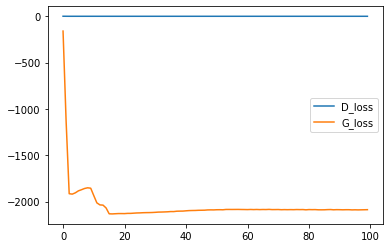

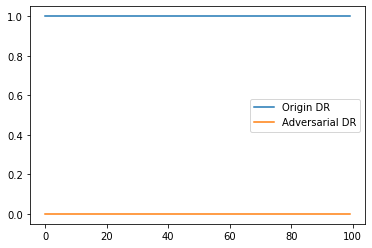

In [17]:
print(f"{40*'='} TRAINING GAN {40*'='}")
print(f"{80*'='}\n IDS Model: {ids_ml_model_name}")

for adversarial_attack_type in ADVERSARIAL_ATTACK_TYPES:
    print(f"{80*'*'}\n  Adversarial Attack Type : {ADVERSARIAL_ATTACK_TYPES_MAP[adversarial_attack_type]}")
    for attack_category in ATTACK_CATEGORIES:
        print(f"{80*'-'}\n    Attack Category: {attack_category}")
        total_time_start = timeit.default_timer()

        # Load sklearn IDS Model
        ids_save_name = ids_ml_model_name + ".pkl"
        if load_ids_model_with_created_date:
            if ids_created_date == "":
                raise ValueError("Invalid ids_created_date: Please check ids_created_date in the Option table")
            else:
                ids_save_name = f"created_date_{ids_created_date}_" + ids_save_name 
        # ids_model = load_sklearn_ids_model(ids_save_name, attack_category)
        ids_model = load_sklearn_ids_model(ids_save_name)
        # Init GAN-G model
        # G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES)     # Generator output is number of nonfunctional feature
        print(f"    nf              : {G_OUTPUT_DIM} (num. of nonfunctional features)")
        if adversarial_attack_type == 1:
            NOISE_DIM = NOISE_DIM_OPTION
        else:
            NOISE_DIM = G_OUTPUT_DIM                                        # Adversarial Attack Type 3,4: Noise dim = nonfunctional feature
        G_INPUT_DIM = NOISE_DIM                                             # G_INPUT_DIM = NOISE_DIM
        print(f"    GAN-G NOISE DIM : {NOISE_DIM}")
        print(f"    GAN-G INPUT DIM : {G_INPUT_DIM}")
        print(f"    GAN-G OUTPUT DIM: {G_OUTPUT_DIM}")
        generator = init_generator(G_INPUT_DIM,G_OUTPUT_DIM, adversarial_attack_type)
        optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
        # Load Raw Attack Dataset
        # raw_attack = preprocess_malicious_data(g_train_data, attack_category)
        raw_attack = preprocess_malicious_data(g_train_data)
        # Prepare Save Folder
        GAN_4IDS_Model_Path = str(f"{GAN_MODEL_PATH}Machine_Learning/{ids_ml_model_name}/")
        if not os.path.exists(GAN_4IDS_Model_Path):
            os.makedirs(GAN_4IDS_Model_Path)
        
        GAN_Save_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/{adversarial_attack_type}/")
        if not os.path.exists(GAN_Save_Path):
            os.makedirs(GAN_Save_Path)

        # Create batch of attack traffic
        batch_attack = create_batch2(raw_attack,BATCH_SIZE)
        # Declare Loss, DR List and Train GAN-G, GAN-D
        d_losses,g_losses = [],[]
        o_dr, a_dr = [],[]
        generator.train()
        discriminator.train()

        # Start Training
        print(f"-->IDSGAN start training")
        print(f"{4*' '}Folder for saving GAN Models : {GAN_Save_Path}")
        labels = ['Epoch', 'G-Loss', 'D-Loss', 'O-DR(%)', 'A-DR(%)', 'Runtime(s)']
        print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*labels))
        for epoch in range(MAX_EPOCH):
            batch_normal = create_batch2(normal,BATCH_SIZE)
            epoch_time_start = timeit.default_timer()
            cnt = 0
            run_g_loss = 0.
            run_d_loss = 0.
            epoch_o_drs, epoch_a_drs = [], []

            for idx, bn in enumerate(batch_normal):
                normal_b = th.Tensor(bn.astype("float64"))
                attack_traffic  = V(th.Tensor(batch_attack[idx % len(batch_attack)]))
                #  Train Generator
                g_loss = train_generator(generator, discriminator, optimizer_G, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type)
                run_g_loss += g_loss.item()

                # Train Discriminator
                d_loss, current_cnt = train_discriminator(discriminator, ids_model, generator, CRITIC_ITERS, CLAMP, optimizer_D, normal_b, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type)
                run_d_loss += d_loss
                cnt += current_cnt
                
                # CALC Epoch DR
                adversarial_attack = gen_adversarial_attack(generator, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type).detach()
                origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_traffic, adversarial_attack)
                epoch_o_drs.append(origin_dr)
                epoch_a_drs.append(adversarial_dr)

            if cnt >= (len(normal)/BATCH_SIZE):
                print("Not exist predicted attack traffic")
                break
            d_losses.append(run_d_loss/CRITIC_ITERS)
            g_losses.append(run_g_loss)
            epoch_o_dr = np.mean(epoch_o_drs)
            epoch_a_dr = np.mean(epoch_a_drs)
            o_dr.append(epoch_o_dr)
            a_dr.append(epoch_a_dr)
            
            runtime = timeit.default_timer() - epoch_time_start
            print_vals = [(epoch + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (epoch_o_dr*100), (epoch_a_dr*100), runtime]
            print_string = []
            for val in print_vals:
                if isinstance(val, float):
                    print_string.append(str(f"{val:.2f}"))
                else:
                    print_string.append(str(val))
            print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*print_string))

            # Save GAN-G Model each 10 epoch
            if (epoch == 0 or (epoch + 1) % 10 == 0):
                if save_gan_model_with_created_date:
                    model_g_save_name = f"time_created_{today}_GAN_G_{epoch+1}epoch.pth"
                else:
                    model_g_save_name = f"GAN_G_{epoch+1}epoch.pth"
                path = GAN_Save_Path + model_g_save_name
                th.save(generator.state_dict(), path)
                print(f"{6*' '}-> GAN-G - {attack_category} - A{adversarial_attack_type} Saved: {model_g_save_name}")
        total_runtime = timeit.default_timer() - total_time_start

        # Save GAN-D Model
        if save_gan_model_with_created_date:
            model_d_save_name = f"time_created_{today}_GAN_D_{MAX_EPOCH}epoch.pth"
        else:
            model_d_save_name = f"GAN_D_{MAX_EPOCH}epoch.pth"
        path = GAN_Save_Path + model_d_save_name
        th.save(discriminator.state_dict(), path)
        print(f"{6*' '}-> GAN-D - {attack_category} - A{adversarial_attack_type} Saved: {model_d_save_name}")
        print(f"Training Runtime: {total_runtime:.2f}")
        print("IDSGAN finish training!")
        
        # Show Graph
        # Loss-Graph
        plt.plot(d_losses,label = "D_loss")
        plt.plot(g_losses, label = "G_loss")
        plt.legend()
        plt.show()
        # DR-Graph
        plt.plot(o_dr,label = "Origin DR")
        plt.plot(a_dr, label = "Adversarial DR")
        plt.legend()
        plt.show()


## **3.2 Run Generate Adversarial Traffic**

In [18]:
# Hyber Parameters
BATCH_SIZE = 256 # Batch size

In [19]:
gan_model_time_created = str(date.today())

# Load Testset
testset = pd.read_csv(testset_path)
print(f"Amount of Test set: \t\t{len(testset)}")
# test_normal
test_normal = np.array(testset[testset["Label"] == 'Benign'])[:,:-1]
# Create batch of normal traffic
test_batch_normal = create_batch2(test_normal,BATCH_SIZE).astype('float64')
print(f"Amount of Normal:\t\t{len(test_normal)} ({len(test_batch_normal)} batchs - {BATCH_SIZE} records/batch)")

Amount of Test set: 		208914
Amount of Normal:		143483 (560 batchs - 256 records/batch)


In [20]:
# Adversarial Traffic Evaluating
print(f"{40*'='} ADVERSARIAL TRAFFIC EVALUATING {40*'='}")
print(f"{80*'='}\n IDS Model: {ids_ml_model_name}")

for adversarial_attack_type in ADVERSARIAL_ATTACK_TYPES:
    print(f"{80*'*'}\n Adversarial Attack Type : {ADVERSARIAL_ATTACK_TYPES_MAP[adversarial_attack_type]}")
    for attack_category in ATTACK_CATEGORIES:
        print(f"{80*'-'}\n - Attack Category: {attack_category}")
        
        # Load sklearn IDS Model
        ids_save_name = ids_ml_model_name + ".pkl"
        if load_ids_model_with_created_date:
            if ids_created_date == "":
                raise ValueError("Invalid ids_created_date: Please check ids_created_date in the Option table")
            else:
                ids_save_name = f"created_date_{ids_created_date}_" + ids_save_name
        ids_model = load_sklearn_ids_model(ids_save_name, attack_category)

        # Init GAN-G model
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES)      # Generator input dimension is dimention of noise
        print(f"    nf              : {G_OUTPUT_DIM} (num. of nonfunctional features)")
        if adversarial_attack_type == 4 or adversarial_attack_type == 3:
            NOISE_DIM = G_OUTPUT_DIM                                        # Adversarial Attack Type 3,4: Noise dim = nonfunctional feature
        else:
            NOISE_DIM = NOISE_DIM_OPTION

        G_INPUT_DIM = NOISE_DIM                                             # G_INPUT_DIM = NOISE_DIM
        print(f"    GAN-G NOISE DIM : {NOISE_DIM}")
        print(f"    GAN-G INPUT DIM : {G_INPUT_DIM}")
        print(f"    GAN-G OUTPUT DIM: {G_OUTPUT_DIM}")
        generator = init_generator(G_INPUT_DIM,G_OUTPUT_DIM, adversarial_attack_type)
        # Load Attack Dataset
        test_raw_attack = preprocess_malicious_data(testset)
        # Create batch of attack traffic
        batch_attack = create_batch2(test_raw_attack, BATCH_SIZE)
        n_batch_attack = len(batch_attack)
        print(f"{4*' '}Amount of {attack_category}:\t{len(test_raw_attack)} ({n_batch_attack} batchs - {BATCH_SIZE} records/batch)")
        
        # Calc DR through each epoch
        gan_g_folder_path = str(f"{GAN_MODEL_PATH}Machine_Learning/{ids_ml_model_name}/{attack_category}/{adversarial_attack_type}/")
        print(f"{4*' '}GAN Models Folder: {gan_g_folder_path}")
        for epoch in range(0, MAX_EPOCH + 1, 10):
            # Load GAN-G Model
            if save_gan_model_with_created_date:
                model_g_save_name = f"time_created_{gan_model_time_created}_GAN_G_{1 if epoch == 0 else epoch}epoch.pth"
            else:
                model_g_save_name = f"GAN_G_{1 if epoch == 0 else epoch}epoch.pth"
            gan_g_model_path = gan_g_folder_path + model_g_save_name
            param = th.load(gan_g_model_path,map_location=lambda x,y:x)
            generator.load_state_dict(param)
            generator.eval()

            o_dr,a_dr =[],[]
            with th.no_grad():
                for idx, bn in enumerate(test_batch_normal):
                    normal_b = th.Tensor(bn)
                    attack_b = th.Tensor(batch_attack[idx % n_batch_attack])
                    # Generate Adversarial Traffic
                    adversarial_attack_b = gen_adversarial_attack(generator, NOISE_DIM, attack_b, attack_category, adversarial_attack_type).detach()

                    # Calc DR
                    origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_b, adversarial_attack_b)
                    o_dr.append(origin_dr)
                    a_dr.append(adversarial_dr)
            eir = 1 - (np.mean(a_dr)/np.mean(o_dr))
            print(f"   Model Name: {model_g_save_name}")
            print(f"\t {epoch:3d} epochs:\tOrigin DR : {np.mean(o_dr)*100:.2f}% \t Adversarial DR : {np.mean(a_dr)*100:.2f}% \t EIR : {eir*100:.2f}%")

======================================== ADVERSARIAL TRAFFIC EVALUATING ========================================
 IDS Model: DT
********************************************************************************
 Adversarial Attack Type : noise-nf (type 4)
--------------------------------------------------------------------------------
 - Attack Category: DOS
    Loaded IDS Model From: /content/drive/My Drive/WORKING - InSecLab/Google Colab/GAN/X.Leopard/Run_On_CICIDS-2018/3. Save Model/IDSModel/Machine_Learning/DT.pkl
    nf              : 61 (num. of nonfunctional features)
    GAN-G NOISE DIM : 61
    GAN-G INPUT DIM : 61
    GAN-G OUTPUT DIM: 61
    Amount of DOS:	208914 (816 batchs - 256 records/batch)
    GAN Models Folder: /content/drive/My Drive/WORKING - InSecLab/Google Colab/GAN/X.Leopard/Run_On_CICIDS-2018/3. Save Model/GANModel/Machine_Learning/DT/DOS/4/
   Model Name: GAN_G_1epoch.pth
	   0 epochs:	Origin DR : 31.32% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
   Model Name: GAN

The Saved Model stored in [Google Drive - GAN Model](https://drive.google.com/drive/u/1/folders/1VNFW-k5SbR0eGsJ_np3U-W3Rcz_n4I8N)

The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)